In [1]:
from keras.layers.wrappers import Bidirectional

In [2]:
import tensorflow as tf

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display_png
from gensim.models import word2vec, KeyedVectors
from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, Dropout, Flatten, LSTM,Bidirectional,GlobalAveragePooling1D
from keras.utils import to_categorical, plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [9]:
!pip install contractions
import pandas as pd
import contractions
import nltk
from nltk.tokenize import word_tokenize
nltk.download('all')
nltk.download('averaged_perceptron_tagger')
import spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

In [5]:

!gdown --id 1bzFpqbhQAaafjwOckOh2abRhrv7CVLeN

Downloading...
From: https://drive.google.com/uc?id=1bzFpqbhQAaafjwOckOh2abRhrv7CVLeN
To: /content/GoogleNews-vectors-negative300.bin
3.64GB [01:13, 49.5MB/s]


# **Feauture Engineering**

In [7]:
data = pd.read_csv('lab4_train.csv')

In [10]:
conflict_word_list = ['but','although','though','despite','spite','nevertheless','however','nonetheless','notwithstanding','contray','contrast']

def lemma_filter(string_text):
  lemma_filter_list = []
  result = []
  contracts = contractions.fix(string_text) #เปลี่ยนคำย่อ สมมติว่า didn't เป็น did not 
  doc = nlp(contracts)
  lemma = [token.lemma_ for token in doc]
  pos_sentences=nltk.pos_tag(lemma)
  for tup in pos_sentences:
      if tup[1].startswith(('J','N','R','V')) or tup[0] in conflict_word_list  == True  : #เอา adj noun adv ไว้
        lemma_filter_list.append(tup[0])
  
  return lemma_filter_list

data['tokens'] = data['text'].apply(lemma_filter)

In [11]:
lemma_filter(data['text'][0])

['staff', 'be', 'so', 'horrible', '-PRON-']

In [12]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [13]:
vocab_in_data = set()
check_data_bigram = data['tokens']
for row in check_data_bigram:
  for bi in row:
    vocab_in_data.add(bi)
  
  
print(len(vocab_in_data))

3544


In [14]:
vector_dim = model.vector_size

In [15]:
vector_dim

300

In [16]:
max_len = 100

In [17]:
vocab_size = len(vocab_in_data)  +1

In [18]:
vocab_size

3545

In [19]:
word_to_index = {'PADDING':0}

# make weight matrix of word embedding, vocab size + 1 (for padding)
embedding_matrix = np.zeros((vocab_size, vector_dim), dtype="float32")
embedding_matrix[0] = np.zeros(vector_dim)

for i, word in enumerate(vocab_in_data & set(model.vocab)):
    word_to_index[word] = i+1
    embedding_matrix[i+1] = model[word] 

In [20]:
import numpy as np
train, dev = np.split(data, [int(0.8 * len(data))])

In [21]:
def w2i(tokens):
    return [word_to_index.get(word, 0) for word in tokens[:max_len]]

# apply functions & convert to np.array
input_train = np.array(train['tokens'].apply(w2i).tolist())
input_dev = np.array(dev['tokens'].apply(w2i).tolist())

 
# input : zero padding
train_x = pad_sequences(input_train, max_len, padding='post')
dev_x = pad_sequences(input_dev, max_len, padding='post')

In [22]:
#function for relabel
def repolar(polarity): #relabel of polarity
    return {'negative':0, 'positive':1, 'conflict':2, 'neutral':3}[polarity]
def reaspect(aspect): #relabel of aspect
    return {'service':0, 'food':1, 'anecdotes/miscellaneous':2, 'price':3,'ambience':4}[aspect]
def index_to_label(polarity_index): #convert back to label
    return {0: 'negative', 1: 'positive', 2: 'conflict', 3: 'neutral'}[polarity_index]
def index_to_aspect(aspect_index): #convert back to label
    return {0:'service', 1:'food', 2:'anecdotes/miscellaneous', 3:'price',4:'ambience'}[aspect_index]

In [23]:
# apply functions & convert to np.array
label_train = np.array(train['polarity'].apply(repolar).tolist())
label_dev = np.array(dev['polarity'].apply(repolar).tolist())

aspect_train = np.array(train['aspectCategory'].apply(reaspect).tolist())
aspect_dev = np.array(dev['aspectCategory'].apply(reaspect).tolist())

# label : one-hot vector
train_label = to_categorical(label_train, num_classes=4)
dev_label = to_categorical(label_dev, num_classes=4)

train_aspect = to_categorical(aspect_train, num_classes=5)
dev_aspect = to_categorical(aspect_dev, num_classes=5)

# **Model for polarity**

In [24]:
# instantiation
p_model = Sequential()

# add embedding layer
p_model.add(Embedding(input_dim=vocab_size,
                    input_length=max_len,
                    output_dim=vector_dim, 
                    weights=[embedding_matrix], 
                    mask_zero=True,
                    trainable=True))

# average
p_model.add(Bidirectional(LSTM(200,recurrent_dropout = 0.2)))
# add hidden layer
p_model.add(Dense(250, activation='relu'))
p_model.add(Dropout(0.20))
p_model.add(Dense(70, activation='relu'))
# add output layer
p_model.add(Dense(4, activation='softmax'))

# compile model
p_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

p_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          1063500   
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               801600    
_________________________________________________________________
dense (Dense)                (None, 250)               100250    
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                17570     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 284       
Total params: 1,983,204
Trainable params: 1,983,204
Non-trainable params: 0
______________________________________________

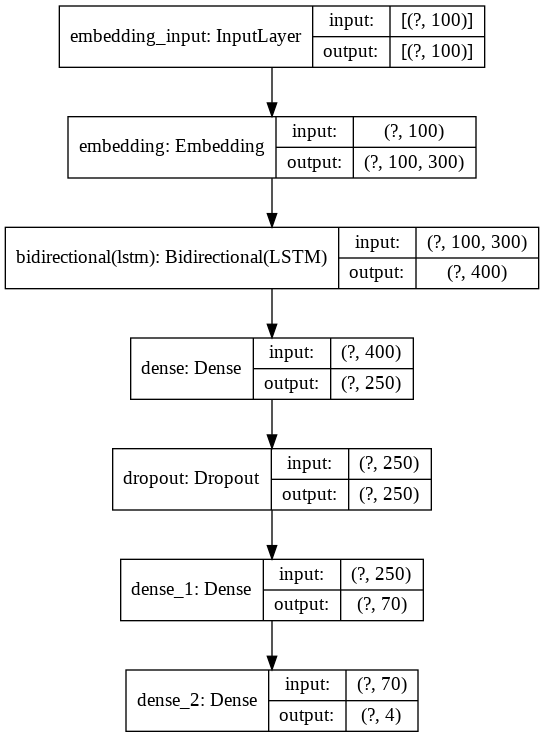

In [25]:
plot_model(p_model, show_shapes=True,to_file='model.png')
display_png(Image('model.png'))

In [26]:
# train
history = p_model.fit(train_x, train_label, batch_size=128, epochs=10, validation_data=(dev_x, dev_label))

Epoch 1/10
20/20 [==============================] - 33s 2s/step - loss: 1.0392 - accuracy: 0.5761 - val_loss: 0.8573 - val_accuracy: 0.6503
Epoch 2/10
20/20 [==============================] - 33s 2s/step - loss: 0.8168 - accuracy: 0.6759 - val_loss: 0.8029 - val_accuracy: 0.6804
Epoch 3/10
20/20 [==============================] - 43s 2s/step - loss: 0.6720 - accuracy: 0.7421 - val_loss: 0.7607 - val_accuracy: 0.7009
Epoch 4/10
20/20 [==============================] - 35s 2s/step - loss: 0.5715 - accuracy: 0.7904 - val_loss: 0.8201 - val_accuracy: 0.7136
Epoch 5/10
20/20 [==============================] - 32s 2s/step - loss: 0.4945 - accuracy: 0.8118 - val_loss: 0.8217 - val_accuracy: 0.7152
Epoch 6/10
20/20 [==============================] - 32s 2s/step - loss: 0.3940 - accuracy: 0.8494 - val_loss: 0.9178 - val_accuracy: 0.6820
Epoch 7/10
20/20 [==============================] - 32s 2s/step - loss: 0.3478 - accuracy: 0.8669 - val_loss: 0.9689 - val_accuracy: 0.6962
Epoch 8/10
20/20 [==

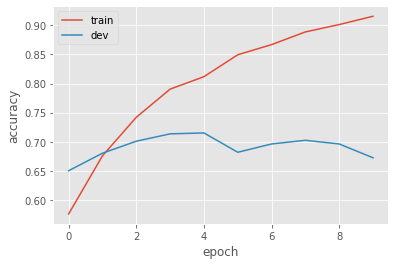

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [29]:
!gdown --id 1YtAHCzeZUXGZQ9cimdkkUq4lUk3ZH-I_

Downloading...
From: https://drive.google.com/uc?id=1YtAHCzeZUXGZQ9cimdkkUq4lUk3ZH-I_
To: /content/evaluate.py
100% 7.03k/7.03k [00:00<00:00, 2.89MB/s]


In [30]:
polar_prediction = p_model.predict(dev_x)
polar_prediction = [index_to_label(np.argmax(i)) for i in polar_prediction]


# **Model for aspect**

In [43]:
#Aspect
# instantiation
a_model = Sequential()

# add embedding layer
a_model.add(Embedding(input_dim=vocab_size,
                    input_length=max_len,
                    output_dim=vector_dim, 
                    weights=[embedding_matrix], 
                    mask_zero=True,
                    trainable=True))

# average
a_model.add(Bidirectional(LSTM(200,recurrent_dropout = 0.2)))

# add hidden layer
a_model.add(Dense(250, activation='relu'))
a_model.add(Dropout(0.20))
a_model.add(Dense(70, activation='relu'))


# add output layer
a_model.add(Dense(5, activation='softmax'))

# compile model
a_model.compile(optimizer="rmsprop",loss="categorical_crossentropy", metrics=["accuracy"])

a_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          1063500   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 400)               801600    
_________________________________________________________________
dense_12 (Dense)             (None, 250)               100250    
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 70)                17570     
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 355       
Total params: 1,983,275
Trainable params: 1,983,275
Non-trainable params: 0
____________________________________________

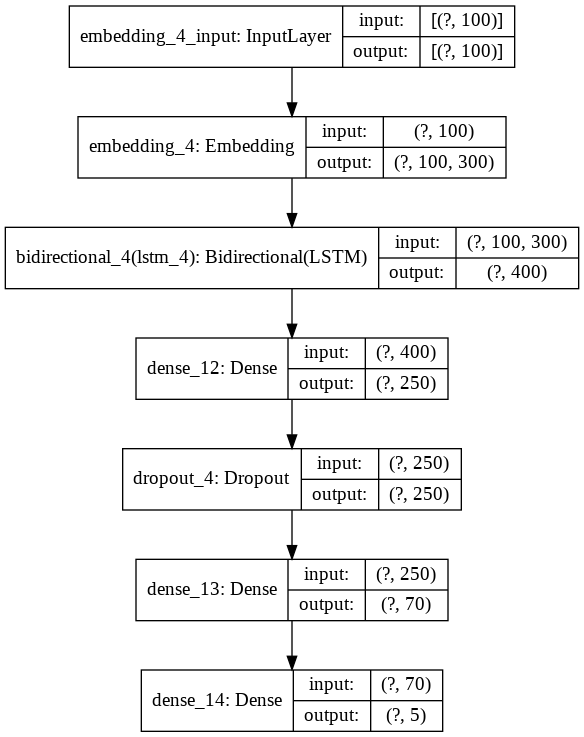

In [44]:
plot_model(a_model, show_shapes=True,to_file='model.png')
display_png(Image('model.png'))

In [45]:
history = a_model.fit(train_x, train_aspect, batch_size=128, epochs=10, validation_data=(dev_x, dev_aspect))

Epoch 1/10
20/20 [==============================] - 32s 2s/step - loss: 1.2938 - accuracy: 0.4980 - val_loss: 1.0066 - val_accuracy: 0.6392
Epoch 2/10
20/20 [==============================] - 32s 2s/step - loss: 0.8841 - accuracy: 0.6759 - val_loss: 0.8882 - val_accuracy: 0.6519
Epoch 3/10
20/20 [==============================] - 32s 2s/step - loss: 0.7248 - accuracy: 0.7183 - val_loss: 0.8592 - val_accuracy: 0.6646
Epoch 4/10
20/20 [==============================] - 31s 2s/step - loss: 0.6108 - accuracy: 0.7500 - val_loss: 0.8632 - val_accuracy: 0.6851
Epoch 5/10
20/20 [==============================] - 32s 2s/step - loss: 0.5489 - accuracy: 0.7587 - val_loss: 0.8890 - val_accuracy: 0.6835
Epoch 6/10
20/20 [==============================] - 31s 2s/step - loss: 0.5086 - accuracy: 0.7627 - val_loss: 0.8629 - val_accuracy: 0.6772
Epoch 7/10
20/20 [==============================] - 32s 2s/step - loss: 0.4461 - accuracy: 0.7845 - val_loss: 1.0423 - val_accuracy: 0.6487
Epoch 8/10
20/20 [==

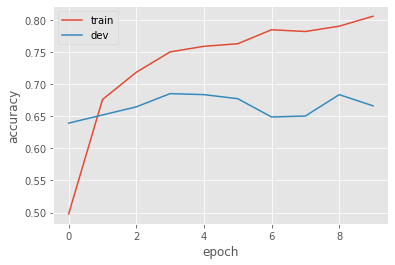

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [63]:
aspect_prediction = a_model.predict(dev_x)
aspect_prediction = [index_to_aspect(np.argmax(i)) for i in aspect_prediction]

In [64]:
file = pd.DataFrame()
file['id'] = dev['id']
file['polarity'] = polar_prediction
file['aspectCategory'] = aspect_prediction
file.to_csv('pred.csv', index=None)
file

,id,polarity,aspectCategory
2524,3235,positive,service
2525,3480,neutral,anecdotes/miscellaneous
2526,1459,positive,food
2527,1459,positive,food
2528,1597,positive,food
...,...,...,...
3151,2853,positive,anecdotes/miscellaneous
3152,1163,positive,service
3153,216,positive,anecdotes/miscellaneous
3154,1109,positive,food


In [65]:
!python3 evaluate.py lab4_train.csv pred.csv

=== CLASSIFICATION : ASPECT ===
                class name  precision  recall  F1-score support
0                     food      0.920   0.788     0.849     203
1                    price      0.900   0.300     0.450      60
2                  service      0.889   0.538     0.671     104
3                 ambience      0.903   0.394     0.549      71
4  anecdotes/miscellaneous      0.761   0.820     0.789     194
5                MACRO AVG      0.874   0.568     0.662     632
6                MICRO AVG      0.847   0.666     0.746     632 

=== CLASSIFICATION : SENTIMENT ===
  class name  precision  recall  F1-score support
0   positive      0.840   0.771     0.804     306
1   negative      0.517   0.720     0.602     125
2    neutral      0.441   0.203     0.278      74
3   conflict      0.250   0.083     0.125      24
4  MACRO AVG      0.512   0.444     0.452     529
5  MICRO AVG      0.690   0.648     0.669     529 

=== CLASSIFICATION : OVERALL ===
              precision  recall  F

In [66]:
!gdown --id 1EacvwnOHfwa4FiZy2K8mFpFjmpb4Mt-t

Downloading...
From: https://drive.google.com/uc?id=1EacvwnOHfwa4FiZy2K8mFpFjmpb4Mt-t
To: /content/lab4_test.csv
100% 36.2k/36.2k [00:00<00:00, 31.0MB/s]


In [67]:
test = pd.read_csv('lab4_test.csv')

In [52]:
test['tokens'] = test['text'].apply(lemma_filter)

In [53]:
def w2i(tokens):
    return [word_to_index.get(word, 0) for word in tokens[:max_len]]

# apply functions & convert to np.array
input_test = np.array(test['tokens'].apply(w2i).tolist()) 
# input : zero padding

test_x = pad_sequences(input_test, max_len, padding='post')

In [54]:
label_train = np.array(train['polarity'].apply(repolar).tolist())
 # label_dev = np.array(dev['polarity'].apply(repolar).tolist())

aspect_train = np.array(train['aspectCategory'].apply(reaspect).tolist())
#aspect_dev = np.array(dev['aspectCategory'].apply(reaspect).tolist())

# label : one-hot vector
train_label = to_categorical(label_train, num_classes=4)
#dev_label = to_categorical(label_dev, num_classes=4)

train_aspect = to_categorical(aspect_train, num_classes=5)
#dev_aspect = to_categorical(aspect_dev, num_classes=5)

In [55]:
polar_p = p_model.predict(test_x)
polar_p = [index_to_label(np.argmax(i)) for i in polar_p]

In [56]:
test.head()

,id,text,tokens
0,899,Food and service was okay.,"[food, service, be, okay]"
1,1349,"great for a romantic evening, or a fun evening...","[great, romantic, evening, fun, evening, friend]"
2,934,The lamb meat was under-cooked and EXTRMELY CH...,"[lamb, meat, be, cook, extrmely, CHEWY]"
3,2199,The best pad thai i've ever had.,"[good, pad, thai, -PRON-, have, ever, have]"
4,188,"Over time, the food quality has decreased subs...","[time, food, quality, have, decrease, substant..."


In [57]:
polar_p

['neutral',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'negative',
 'neutral',
 'negative',
 'positive',
 'negative',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'positive',
 'negative',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'negative',
 'negative',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'negative',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'positive',
 'neutral',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'neutral',

In [58]:
len(polar_p)

461

In [59]:
len(test)

461

In [60]:
aspect_p = a_model.predict(test_x)
aspect_p = [index_to_aspect(np.argmax(i)) for i in aspect_p]

In [61]:
nfile = pd.DataFrame()
nfile['id'] = test['id']
nfile['polarity'] = polar_p
nfile['aspectCategory'] = aspect_p
nfile.to_csv('test_pred.csv', index=None)
nfile

,id,polarity,aspectCategory
0,899,neutral,food
1,1349,positive,anecdotes/miscellaneous
2,934,positive,food
3,2199,positive,food
4,188,negative,service
...,...,...,...
456,1063,positive,anecdotes/miscellaneous
457,777,negative,food
458,875,negative,anecdotes/miscellaneous
459,671,negative,food
